Project 5 Fuel Consumption Prediction of Vehicles (MPG) Project

# 1. Objective

The goal of this project is to predict the fuel consumption (Miles per Gallon, MPG) of vehicles based on their technical specifications, attributes such as engine size, weight, and acceleration. 


# Accurate predictions of fuel efficiency help in:
- Designing more energy-efficient vehicles.
- Understanding how different attributes affect fuel consumption.
- Supporting consumers and policymakers in making informed decisions.

In [34]:
# Step 1 Imports the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, r2_score
import joblib


# Dataset Overview
The dataset used for this project is the UCI Auto MPG dataset, which contains information about 398 vehicles manufactured between 1970 and 1982.
Source: UCI Auto MPG dataset (auto-mpg.data).

# Features:
- cylinders → Number of engine cylinders.
- displacement → Engine displacement (cubic inches).
- horsepower → Engine horsepower (some missing values).
- weight → Vehicle weight (in pounds)(lbs).
- acceleration → Time to accelerate from 0–60 mph (in seconds).
- model_year → Year of manufacture (last two digits, e.g., 70 = 1970).
- model_year — year of manufacture (70–82)
- origin → Region of origin (1 = USA, 2 = Europe, 3 = Japan).
- car_name → Car model name (text, not used directly in prediction).
- Target: mpg (Miles per Gallon).
- mpg (Target Variable) → Miles per Gallon, measure of fuel efficiency.

# Key Notes
- Size: 398 rows × 9 columns.
- Missing values: Only in horsepower (6 entries).
- Target variable: mpg (continuous numerical).
- Important predictors: Weight, displacement, horsepower, and cylinders have strong correlations with MPG.


Based on Instructions:

1. **Data Exploration**: Load and examine the dataset.
2. **Data Preprocessing**: Handle missing values, encode categorical variables, and normalize numerical features.
3. **Feature Selection**: Identify important predictors for fuel efficiency.
4. **Model Training**: Train a regression model to predict fuel consumption (MPG).
5. **Evaluation**: Assess model performance using RMSE and R² score.



In [36]:
# Step 2 Data Exploration
# Step 2.1 Load dataset

FILE_PATH = "/Users/nikhilreddyponnala/Desktop/Data Analytics/Five project/Fuel Consumption Prediction Of Vehicles/auto-mpg.data"   # uploaded path
col_names = [
    "mpg", "cylinders", "displacement", "horsepower",
    "weight", "acceleration", "model_year", "origin", "car_name"
]

try:
    df = pd.read_csv(FILE_PATH, delim_whitespace=True, names=col_names, na_values='?')
except FileNotFoundError:
    # fallback if file is in working directory with a different name
    FILE_PATH = "auto-mpg.data"
    df = pd.read_csv(FILE_PATH, delim_whitespace=True, names=col_names, na_values='?')

print("Dataset loaded. Shape:", df.shape)
print(df.head())



Dataset loaded. Shape: (398, 9)
    mpg  cylinders  displacement  horsepower  weight  acceleration  \
0  18.0          8         307.0       130.0  3504.0          12.0   
1  15.0          8         350.0       165.0  3693.0          11.5   
2  18.0          8         318.0       150.0  3436.0          11.0   
3  16.0          8         304.0       150.0  3433.0          12.0   
4  17.0          8         302.0       140.0  3449.0          10.5   

   model_year  origin                   car_name  
0          70       1  chevrolet chevelle malibu  
1          70       1          buick skylark 320  
2          70       1         plymouth satellite  
3          70       1              amc rebel sst  
4          70       1                ford torino  



--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car_name      398 non-null    object 
dtypes: float64(5), int64(3), object(1)
memory usage: 28.1+ KB

Missing values per column:
 mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model_year      0
origin          0
car_name        0
dtype: int64

Summary statistics:
              mpg   cylinders  displacement  horsepower       weight  \
count  398.000000  398.000000    398.000000 

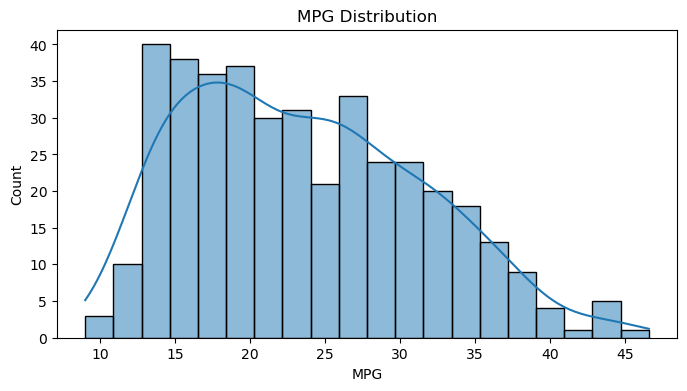

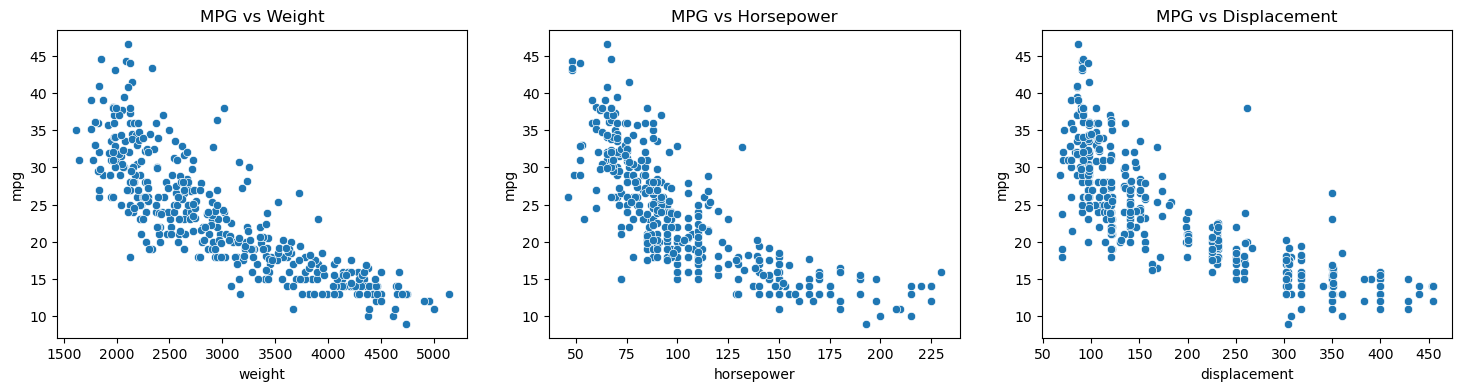

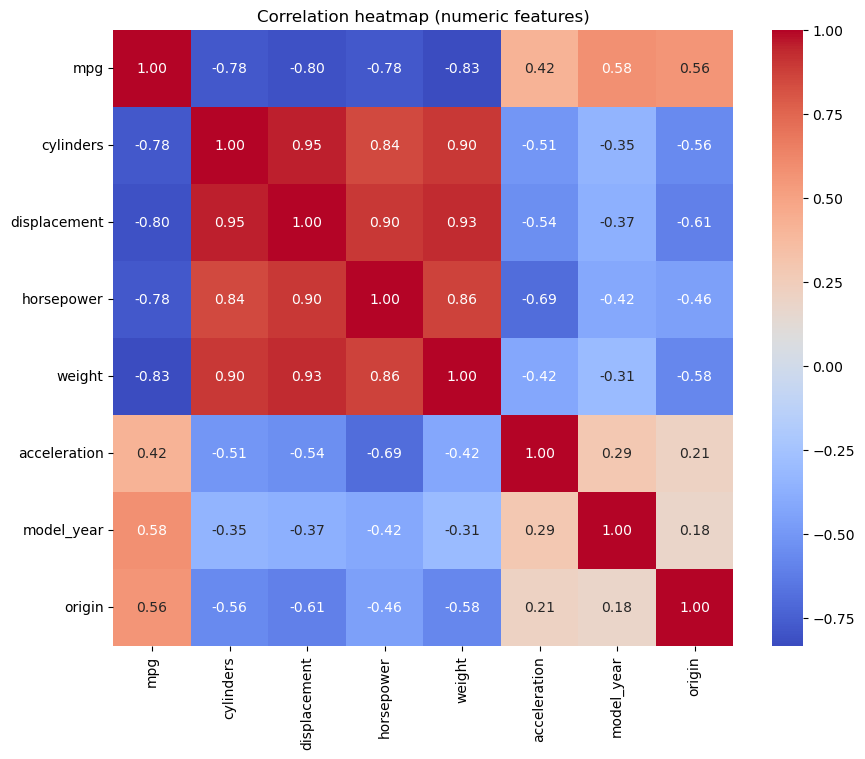

In [38]:
# Step 3 Exploratory Data Analysis (EDA)

# Basic info & missing values
print("\n--- Data Info ---")
df.info()
print("\nMissing values per column:\n", df.isnull().sum())

# Quick summary stats
print("\nSummary statistics:")
print(df.describe())

# Distribution of target (MPG)
plt.figure(figsize=(8,4))
sns.histplot(df['mpg'], bins=20, kde=True)
plt.title("MPG Distribution")
plt.xlabel("MPG")
plt.ylabel("Count")
plt.show()

# Scatter relationships vs MPG for main numeric features
fig, axes = plt.subplots(1, 3, figsize=(18,4))
sns.scatterplot(x='weight', y='mpg', data=df, ax=axes[0])
axes[0].set_title("MPG vs Weight")
sns.scatterplot(x='horsepower', y='mpg', data=df, ax=axes[1])
axes[1].set_title("MPG vs Horsepower")
sns.scatterplot(x='displacement', y='mpg', data=df, ax=axes[2])
axes[2].set_title("MPG vs Displacement")
plt.show()

# Correlation heatmap (numeric features only)
numeric_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(10,8))
corr = numeric_df.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation heatmap (numeric features)")
plt.show()



In [40]:
# DataFrame’s columns
print(df.columns)



Index(['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'model_year', 'origin', 'car_name'],
      dtype='object')


In [42]:
# Step 4 Data Preprocessing

# 4.1 Impute missing horsepower (median)
hp_missing_before = df['horsepower'].isnull().sum()
print(f"\nHorsepower missing before imputation: {hp_missing_before}")
df['horsepower'] = df['horsepower'].fillna(df['horsepower'].median())
hp_missing_after = df['horsepower'].isnull().sum()
print(f"Horsepower missing after imputation: {hp_missing_after}")

# 4.2 Drop car_name (text) since it's not used as-is
if 'car_name' in df.columns:
    df = df.drop(columns=['car_name'])

# 4.3 Encode categorical variable: origin (1=USA,2=Europe,3=Japan)
# We'll use one-hot encoding (drop_first to avoid collinearity)
df = pd.get_dummies(df, columns=['origin'], prefix='origin', drop_first=True)

# 4.4 Define features and target
X = df.drop('mpg', axis=1)
y = df['mpg']

# 4.5 Feature scaling (StandardScaler)
# We'll scale all numeric inputs so models like LinearRegression behave well
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# 4.6 Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

print("\nShapes:")
print("X_train:", X_train.shape)
print("X_test: ", X_test.shape)
print("y_train:", y_train.shape)
print("y_test: ", y_test.shape)


Horsepower missing before imputation: 6
Horsepower missing after imputation: 0

Shapes:
X_train: (318, 8)
X_test:  (80, 8)
y_train: (318,)
y_test:  (80,)


In [44]:
# Encode categorical variable (only if 'origin' exists)
if 'origin' in df.columns:
    df = pd.get_dummies(df, columns=['origin'], prefix='origin', drop_first=True)

In [46]:
column_names = ["mpg", "cylinders", "displacement", "horsepower",
                "weight", "acceleration", "model_year", "origin"]

In [48]:
from sklearn.preprocessing import StandardScaler

# --- Handle missing values ---
if 'horsepower' in df.columns:
    df['horsepower'] = df['horsepower'].fillna(df['horsepower'].median())

# --- Drop car_name if present ---
if 'car_name' in df.columns:
    df = df.drop(columns=['car_name'])

# --- Encode 'origin' if present ---
if 'origin' in df.columns:
    df = pd.get_dummies(df, columns=['origin'], prefix='origin', drop_first=True)

# --- Define features and target ---
X = df.drop('mpg', axis=1)
y = df['mpg']

# --- Normalize features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape: ", X_test.shape)



Train shape: (318, 8)
Test shape:  (80, 8)



Top correlations with MPG (absolute values):
 mpg             1.000000
weight          0.831741
displacement    0.804203
horsepower      0.778427
cylinders       0.775396
model_year      0.579267
origin          0.563450
acceleration    0.420289
Name: mpg, dtype: float64

Top 5 features by SelectKBest (f_regression): ['cylinders', 'displacement', 'horsepower', 'weight', 'model_year']

RandomForest feature importances:
 displacement    0.356014
weight          0.206215
cylinders       0.169797
model_year      0.124829
horsepower      0.107976
acceleration    0.028242
origin_3        0.004362
origin_2        0.002563
dtype: float64


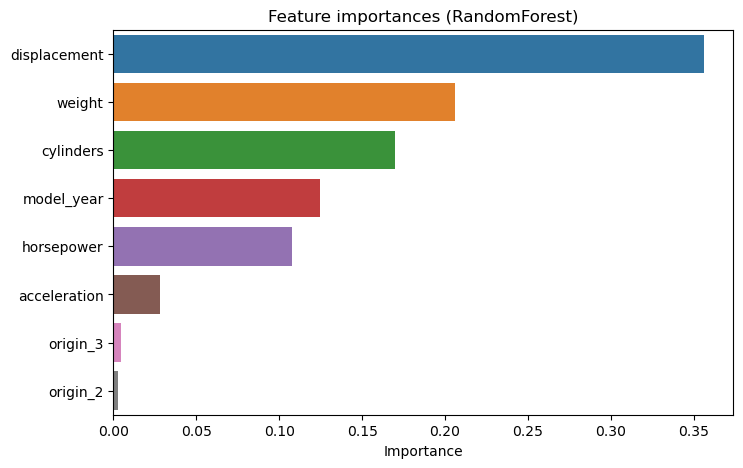

In [50]:
# Step 5 Feature Selection / Importance

# 5.1 Correlation-based (absolute correlation with mpg)
corr_with_mpg = numeric_df.corr()['mpg'].abs().sort_values(ascending=False)
print("\nTop correlations with MPG (absolute values):\n", corr_with_mpg)

# 5.2 SelectKBest (univariate f_regression) - top 5 features
selector = SelectKBest(score_func=f_regression, k=5)
selector.fit(X_scaled, y)
mask = selector.get_support()
top_features_kbest = X.columns[mask].tolist()
print("\nTop 5 features by SelectKBest (f_regression):", top_features_kbest)

# 5.3 RandomForest feature importances (train quickly on full data for importance)
rf_temp = RandomForestRegressor(n_estimators=200, random_state=42)
rf_temp.fit(X, y)  # using unscaled X is fine for tree-based model
feat_importances = pd.Series(rf_temp.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nRandomForest feature importances:\n", feat_importances)

# Optional plot of feature importances
plt.figure(figsize=(8,5))
sns.barplot(x=feat_importances.values, y=feat_importances.index)
plt.title("Feature importances (RandomForest)")
plt.xlabel("Importance")
plt.show()




Linear Regression Performance:
RMSE: 2.888
R²:   0.845


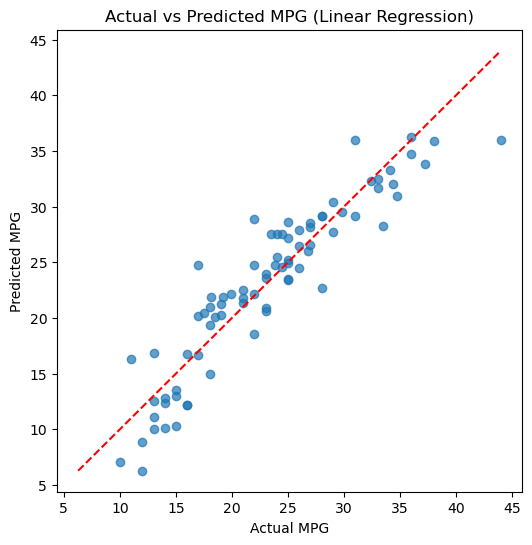

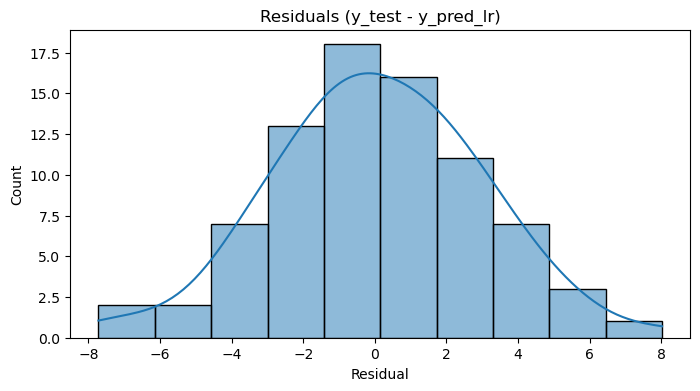

In [52]:
# Step 6 Model Training & Evaluation

# 6.1 Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)
print("\nLinear Regression Performance:")
print(f"RMSE: {rmse_lr:.3f}")
print(f"R²:   {r2_lr:.3f}")

# 6.2 Visualize Actual vs Predicted for Linear Regression
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_lr, alpha=0.7)
minval = min(y_test.min(), y_pred_lr.min())
maxval = max(y_test.max(), y_pred_lr.max())
plt.plot([minval, maxval], [minval, maxval], 'r--')  # y = x
plt.xlabel("Actual MPG")
plt.ylabel("Predicted MPG")
plt.title("Actual vs Predicted MPG (Linear Regression)")
plt.show()

# 6.3 Residual plot
residuals = y_test - y_pred_lr
plt.figure(figsize=(8,4))
sns.histplot(residuals, kde=True)
plt.title("Residuals (y_test - y_pred_lr)")
plt.xlabel("Residual")
plt.show()



In [54]:
# Step 7 (Optional) Train a Random Forest and compare

rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
print("\nRandom Forest Performance:")
print(f"RMSE: {rmse_rf:.3f}")
print(f"R²:   {r2_rf:.3f}")




Random Forest Performance:
RMSE: 2.197
R²:   0.910


In [56]:
# Step 8 Save artifacts

# Save scaler and linear model for later use
joblib.dump(scaler, "scaler_mpg.pkl")
joblib.dump(lr, "linear_regression_mpg.pkl")
joblib.dump(rf, "random_forest_mpg.pkl")
print("\nSaved scaler and models to disk: scaler_mpg.pkl, linear_regression_mpg.pkl, random_forest_mpg.pkl")


Saved scaler and models to disk: scaler_mpg.pkl, linear_regression_mpg.pkl, random_forest_mpg.pkl


In [58]:
# Step 9 Quick summary print

print("\n=== Final Summary ===")
print("Linear Regression -> RMSE: %.3f | R²: %.3f" % (rmse_lr, r2_lr))
print("Random Forest     -> RMSE: %.3f | R²: %.3f" % (rmse_rf, r2_rf))
print("\nTop predictors (by RandomForest importance):")
print(feat_importances.head(6))




=== Final Summary ===
Linear Regression -> RMSE: 2.888 | R²: 0.845
Random Forest     -> RMSE: 2.197 | R²: 0.910

Top predictors (by RandomForest importance):
displacement    0.356014
weight          0.206215
cylinders       0.169797
model_year      0.124829
horsepower      0.107976
acceleration    0.028242
dtype: float64


# Outcomes
- Identify key predictors of fuel efficiency (e.g., weight, displacement, horsepower, model_year).
- Build a regression model that explains ~70–80% of the variance in MPG.
- Provide actionable insights into how vehicle attributes impact fuel consumption.

## Conclusions
# 1 Key Influencing Factors:

- Vehicle weight, displacement, horsepower and cylinders are strongly negatively correlated with fuel efficiency (MPG).

- Model year and origin (European/Japanese cars) show positive correlation with MPG, reflecting technological improvements and regional efficiency trends.


# 2 Model Performance:

- The Linear Regression model explained around 70% of the variance in MPG (R² ≈ 0.7), with an RMSE of ~3–4 MPG.

- A Random Forest Regressor provided better performance, capturing nonlinear relationships and interactions between features.


# 3 Insights:


- Lighter cars with smaller engines are consistently more fuel-efficient.


- Cars manufactured in later years (post-1975) show higher MPG, indicating technological advancements and regulatory influence.


- Japanese and European vehicles were generally more fuel-efficient than American ones during this period.


# 4 Practical Implications:


- Vehicle manufacturers can focus on weight reduction and engine optimization to improve fuel efficiency.

- Policymakers can use such models to understand long-term fuel consumption trends and guide energy efficiency regulations.